# XJTU-SY 베어링 RUL 회귀 실습 (정답 노트북)

이 노트북은 `src/data_utils.py`와 `src/models.py`를 활용하여
XJTU-SY 베어링 데이터셋 기반 RUL 회귀 모델을 학습하는 end-to-end 예시입니다.


In [ ]:
import sys
from pathlib import Path

# 현재 노트북 파일이 notebooks/ 폴더 안에 있다고 가정
this_file = Path.cwd()  # 보통은 notebooks/ 경로
project_root = this_file.parent  # notebooks/ 상위 디렉토리 = 프로젝트 루트

# 혹시 다른 데서 켰다면, 직접 경로를 지정해도 됨:
# project_root = Path(r"C:/어디/어디/samsung-rul-xjtu-sy")

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("project_root:", project_root)
print("sys.path 에 추가됨:", project_root in map(Path, sys.path))

project_root: c:\Users\dhshs\Downloads\samsung-edu-kjh
sys.path 에 추가됨: True


In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from src.data_utils import build_dataset
from src.models import RULLSTM, count_parameters

# 프로젝트 루트 및 데이터 경로 설정
project_root = Path.cwd().parent  # notebooks/ 상위 디렉토리를 프로젝트 루트로 가정
raw_root = project_root / "data" / "raw" / "XJTU-SY_Bearing_Datasets"

window_size = 20
stride = 1
max_rul = 125.0

batch_size = 64
num_epochs = 100
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Project root:", project_root)
print("Raw data root:", raw_root)
print("Device:", device)


Project root: c:\Users\dhshs\Downloads\samsung-edu-kjh
Raw data root: c:\Users\dhshs\Downloads\samsung-edu-kjh\data\raw\XJTU-SY_Bearing_Datasets
Device: cpu


In [ ]:
# 학습/검증/테스트용 윈도우 데이터 생성
(train_X, train_y), (val_X, val_y), (test_X, test_y) = build_dataset(
    raw_root=str(raw_root),
    window_size=window_size,
    stride=stride,
    max_rul=max_rul,
    split_config=None,  # 기본 run 분할 규칙 사용
)

print("Train X:", train_X.shape, "Train y:", train_y.shape)
print("Val   X:", val_X.shape, "Val   y:", val_y.shape)
print("Test  X:", test_X.shape, "Test  y:", test_y.shape)


Train X: (521, 20, 6) Train y: (521,)
Val   X: (614, 20, 6) Val   y: (614,)
Test  X: (268, 20, 6) Test  y: (268,)


In [ ]:
# 넘파이 배열을 텐서로 변환
def to_tensor(x, y):
    x_t = torch.from_numpy(x).float()
    y_t = torch.from_numpy(y).float()
    return x_t, y_t

train_x_t, train_y_t = to_tensor(train_X, train_y)
val_x_t, val_y_t = to_tensor(val_X, val_y)

train_loader = DataLoader(TensorDataset(train_x_t, train_y_t),
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(TensorDataset(val_x_t, val_y_t),
                        batch_size=batch_size,
                        shuffle=False)

# 모델 정의
input_dim = train_X.shape[-1]
model = RULLSTM(input_dim=input_dim, hidden_dim=64, num_layers=2, dropout=0.1).to(device)
print(model)
print("Trainable params:", count_parameters(model))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


RULLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Trainable params: 51777


In [ ]:
def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_loss += loss.item() * xb.size(0)
            n += xb.size(0)
    return total_loss / max(1, n)


train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    n = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    train_loss = total_loss / max(1, n)
    val_loss = evaluate(model, val_loader, device, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")


c:\Users\dhshs\anaconda3\envs\test\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\dhshs\anaconda3\envs\test\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([9, 1])) that is different to the input size (torch.Size([9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\dhshs\anaconda3\envs\test\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([38, 1])) that is different to the input size (torch.Size([38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the 

Epoch 01 | train_loss=4893.6019 | val_loss=nan
Epoch 02 | train_loss=4764.6149 | val_loss=nan
Epoch 03 | train_loss=4565.2186 | val_loss=nan
Epoch 04 | train_loss=4401.5493 | val_loss=nan
Epoch 05 | train_loss=4278.8929 | val_loss=nan
Epoch 06 | train_loss=4186.9743 | val_loss=nan
Epoch 07 | train_loss=4106.8301 | val_loss=nan
Epoch 08 | train_loss=4034.5991 | val_loss=nan
Epoch 09 | train_loss=3965.7389 | val_loss=nan
Epoch 10 | train_loss=3897.7400 | val_loss=nan
Epoch 11 | train_loss=3834.6401 | val_loss=nan
Epoch 12 | train_loss=3772.2838 | val_loss=nan
Epoch 13 | train_loss=3712.7934 | val_loss=nan
Epoch 14 | train_loss=3651.0674 | val_loss=nan
Epoch 15 | train_loss=3591.9494 | val_loss=nan
Epoch 16 | train_loss=3535.1721 | val_loss=nan
Epoch 17 | train_loss=3480.0944 | val_loss=nan
Epoch 18 | train_loss=3427.0025 | val_loss=nan
Epoch 19 | train_loss=3375.6897 | val_loss=nan
Epoch 20 | train_loss=3324.4086 | val_loss=nan
Epoch 21 | train_loss=3275.2563 | val_loss=nan
Epoch 22 | tr

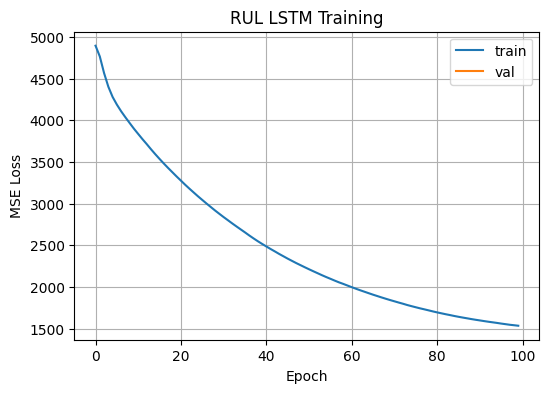

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("RUL LSTM Training")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# 테스트 세트 평가 (MAE)
from sklearn.metrics import mean_absolute_error

test_x_t, test_y_t = to_tensor(test_X, test_y)
test_loader = DataLoader(TensorDataset(test_x_t, test_y_t),
                         batch_size=batch_size,
                         shuffle=False)

model.eval()
preds_list = []
targets_list = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        preds_list.append(preds)
        targets_list.append(yb.numpy())

y_pred = np.concatenate(preds_list, axis=0)
y_true = np.concatenate(targets_list, axis=0)
mae = mean_absolute_error(y_true, y_pred)
print("Test MAE:", mae)


Test MAE: 56.97830581665039
